<a href="https://colab.research.google.com/github/Hrsht02/-Handwritten-Digit-Recognizer/blob/main/Handwritten_Digit_Recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, glob, random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.datasets import mnist
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model

In [2]:
# 1) Load & preprocess the MNIST dataset

def load_and_preprocess_mnist():
    (X_train, y_train), (X_test, y_test) = mnist.load_data()

    # Normalize to [0,1]
    X_train = X_train.astype("float32") / 255.0
    X_test  = X_test.astype("float32") / 255.0

    # Reshape for CNN: add channel dimension (grayscale -> 1)
    X_train = X_train.reshape(-1, 28, 28, 1)
    X_test  = X_test.reshape(-1, 28, 28, 1)
    return (X_train, y_train), (X_test, y_test)

In [4]:
# 2) Build a CNN model

def build_cnn(input_shape=(28,28,1), num_classes=10):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2,2)),

        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D((2,2)),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),  # mild regularization (optional)
        Dense(num_classes, activation='softmax')
    ])
    # Using sparse_categorical_crossentropy because labels are integers (0..9)
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [5]:
# 3) Train with checkpoint + LR scheduler

def train_model(model, X_train, y_train, epochs=10, batch_size=64, val_split=0.2):
    ckpt_path = "best_mnist_cnn.keras"
    ckpt = ModelCheckpoint(
        filepath=ckpt_path,
        monitor="val_accuracy",
        save_best_only=True,
        mode="max",
        verbose=1
    )

    rlrop = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2,
                              min_lr=1e-5, verbose=1)

    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=val_split,
        callbacks=[ckpt, rlrop],
        verbose=2
    )

    # Load best validation-accuracy weights
    model = load_model(ckpt_path)
    return model, history


In [6]:
# 4) Evaluate on the test set

def evaluate(model, X_test, y_test):
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print(f"\n✅ Test Accuracy: {test_acc*100:.2f}%  |  Test Loss: {test_loss:.4f}")
    return test_loss, test_acc


In [7]:
# 5) Plot training & validation learning curves

def plot_learning_curves(history):
    # Accuracy
    plt.figure(figsize=(6,4))
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.title('Accuracy vs Epochs')
    plt.tight_layout(); plt.show()

    # Loss
    plt.figure(figsize=(6,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.title('Loss vs Epochs')
    plt.tight_layout(); plt.show()

In [9]:
# 6) Utilities to predict on your own (unseen) images
# ---------------------------------------------------
def preprocess_image_for_mnist(path, auto_invert=True):
    """
    Convert image at `path` to MNIST-like tensor (1,28,28,1) in [0,1].
    Tries to auto-invert when the background is white.
    """
    img = Image.open(path).convert("L")                # grayscale
    img = ImageOps.autocontrast(img)
    img_28 = ImageOps.fit(img, size=(28, 28), method=Image.LANCZOS, centering=(0.5, 0.5))
    arr = np.array(img_28).astype("float32")

    # If average is bright (white background), invert so strokes are bright like MNIST
    if auto_invert and arr.mean() > 127:
        arr = 255.0 - arr

    arr = arr / 255.0
    arr = arr.reshape(1, 28, 28, 1)                    # (batch, h, w, c)
    return arr, img_28

def predict_single_image(path, model):
    x, disp_img = preprocess_image_for_mnist(path)
    probs = model.predict(x, verbose=0)[0]
    pred = int(np.argmax(probs))
    conf = float(probs[pred])

    plt.figure()
    plt.imshow(disp_img, cmap="gray")
    plt.axis("off")
    plt.title(f"Predicted: {pred}  •  Confidence: {conf:.3f}")
    plt.show()

    print(f"{os.path.basename(path)} -> Predicted {pred} (confidence {conf:.3f})")
    return pred, conf

def predict_folder(folder, model, exts=(".png", ".jpg", ".jpeg", ".bmp", ".webp")):
    paths = sorted([p for p in glob.glob(os.path.join(folder, "*")) if p.lower().endswith(exts)])
    if not paths:
        print("No images found in:", folder)
        return []
    preds = []

    cols = 6
    rows = int(np.ceil(len(paths) / cols))
    plt.figure(figsize=(2.5*cols, 2.5*rows))

    for i, p in enumerate(paths):
        x, disp_img = preprocess_image_for_mnist(p)
        probs = model.predict(x, verbose=0)[0]
        pred = int(np.argmax(probs))
        conf = float(probs[pred])
        preds.append((os.path.basename(p), pred, conf))

        ax = plt.subplot(rows, cols, i+1)
        ax.imshow(disp_img, cmap="gray")
        ax.set_title(f"{pred} ({conf:.2f})", fontsize=9)
        ax.axis("off")

    plt.tight_layout(); plt.show()

    for name, pred, conf in preds:
        print(f"{name}: {pred} ({conf:.3f})")
    return preds



Epoch 1/10

Epoch 1: val_accuracy improved from -inf to 0.98417, saving model to best_mnist_cnn.keras
844/844 - 44s - 53ms/step - accuracy: 0.9380 - loss: 0.2059 - val_accuracy: 0.9842 - val_loss: 0.0571 - learning_rate: 1.0000e-03
Epoch 2/10

Epoch 2: val_accuracy improved from 0.98417 to 0.98850, saving model to best_mnist_cnn.keras
844/844 - 84s - 99ms/step - accuracy: 0.9792 - loss: 0.0674 - val_accuracy: 0.9885 - val_loss: 0.0400 - learning_rate: 1.0000e-03
Epoch 3/10

Epoch 3: val_accuracy did not improve from 0.98850
844/844 - 81s - 96ms/step - accuracy: 0.9860 - loss: 0.0465 - val_accuracy: 0.9880 - val_loss: 0.0467 - learning_rate: 1.0000e-03
Epoch 4/10

Epoch 4: val_accuracy improved from 0.98850 to 0.98883, saving model to best_mnist_cnn.keras
844/844 - 84s - 100ms/step - accuracy: 0.9884 - loss: 0.0369 - val_accuracy: 0.9888 - val_loss: 0.0369 - learning_rate: 1.0000e-03
Epoch 5/10

Epoch 5: val_accuracy improved from 0.98883 to 0.99217, saving model to best_mnist_cnn.keras

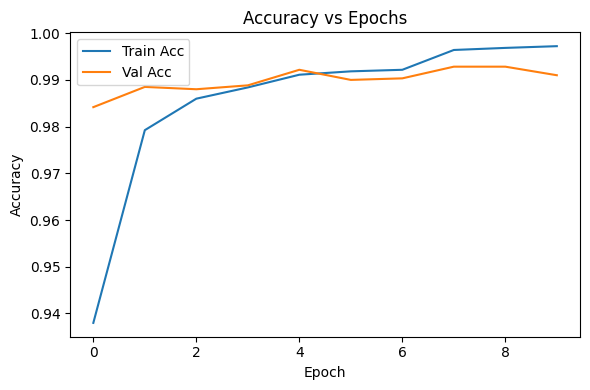

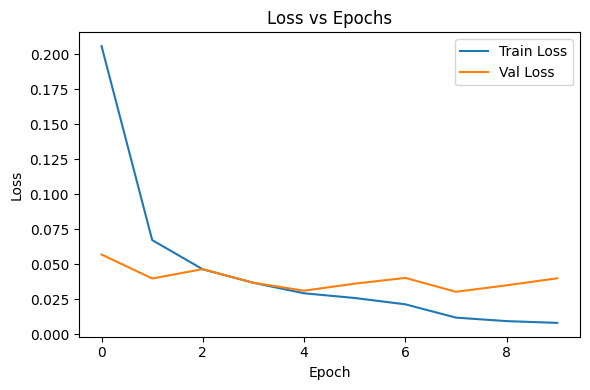

In [11]:
 # 7) Main pipeline

if __name__ == "__main__":
    # A) Data
    (X_train, y_train), (X_test, y_test) = load_and_preprocess_mnist()

    # B) Model
    model = build_cnn()

    # C) Train
    model, history = train_model(model, X_train, y_train, epochs=10, batch_size=64, val_split=0.1)

    # D) Evaluate
    evaluate(model, X_test, y_test)

    # E) Plots
    plot_learning_curves(history)

    # F) Predict on unseen images (optional)
    #    Put your digit images in a folder, e.g., "my_digits/"
    #    Each image can be any size; it will be center-fitted to 28x28.
    #    Uncomment to run:
    #
    # single_image_path = "my_digits/example.png"
    # predict_single_image(single_image_path, model)
    #
    # folder_path = "my_digits"
    # predict_folder(folder_path, model)